In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

### Read training and test datasets

In [ ]:
# helper function for reading datatset
def read_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # convert it to datatime

    return df

In [ ]:
df_train = read_data('/content/kospi_train.csv')
df_test = read_data('/content/kospi_test.csv')

len(df_train), len(df_test)

(986, 244)

In [ ]:
# the training dataset has daily KOSPI index from 2019 to 2022
df_train

,Date,Open,Low,High,Close,Volume
0,2019-01-02,2050.550049,2004.270020,2053.449951,2010.000000,326400
1,2019-01-03,2011.810059,1991.650024,2014.719971,1993.699951,428000
2,2019-01-04,1992.400024,1984.530029,2011.560059,2010.250000,409000
3,2019-01-07,2034.239990,2030.900024,2048.060059,2037.099976,440200
4,2019-01-08,2038.680054,2023.589966,2042.699951,2025.270020,397800
...,...,...,...,...,...,...
981,2022-12-23,2325.860107,2311.899902,2333.080078,2313.689941,367000
982,2022-12-26,2312.540039,2304.199951,2321.919922,2317.139893,427600
983,2022-12-27,2327.520020,2321.479980,2335.989990,2332.790039,448300
984,2022-12-28,2296.449951,2276.899902,2296.449951,2280.449951,405700


In [ ]:
# the test dataset has daily KOSPI index in 2023
df_test

,Date,Open,Low,High,Close,Volume
0,2023-01-02,2249.949951,2222.370117,2259.879883,2225.669922,346100
1,2023-01-03,2230.979980,2180.669922,2230.979980,2218.679932,410000
2,2023-01-04,2205.979980,2198.820068,2260.060059,2255.979980,412700
3,2023-01-05,2268.199951,2252.969971,2281.389893,2264.649902,430800
4,2023-01-06,2253.399902,2253.270020,2300.620117,2289.969971,398300
...,...,...,...,...,...,...
239,2023-12-21,2598.370117,2587.159912,2610.810059,2600.020020,578300
240,2023-12-22,2617.719971,2599.510010,2621.370117,2599.510010,466000
241,2023-12-26,2609.439941,2594.649902,2612.139893,2602.590088,439500
242,2023-12-27,2599.350098,2590.080078,2613.500000,2613.500000,349700


## Part 1. Train regression models to predict the next day's close using Open, Low, High, Close, Volume of previous days as predictors using only df_train. Cross-validate to select the best model. Evaluate the accuracy of your model using df_test.

In [ ]:
# ===== 데이터 준비 =====
df_train['target'] = df_train['Close'].shift(-1)
df_test['target'] = df_test['Close'].shift(-1)
df_train = df_train[:-1].reset_index(drop=True)
df_test = df_test[:-1].reset_index(drop=True)

def create_windowed_data(df, n_days):
    X, y = [], []
    for i in range(len(df) - n_days):
        window = df[['Open', 'High', 'Low', 'Close', 'Volume']].iloc[i:i + n_days].values.flatten()
        target = df['target'].iloc[i + n_days]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

n_days = 3

# 전처리 (Scaling + Windowing)
X_train_scaled, y_train_scaled = create_windowed_data(df_train, n_days)
X_test_scaled, y_test_scaled = create_windowed_data(df_test, n_days)
dates_test_scaled = df_test['Date'].values[n_days:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# 비전처리 (No Scaling, No Windowing)
X_train_raw = df_train[['Open', 'High', 'Low', 'Close', 'Volume']].values
y_train_raw = df_train['target'].values
X_test_raw = df_test[['Open', 'High', 'Low', 'Close', 'Volume']].values
y_test_raw = df_test['target'].values
dates_test_raw = df_test['Date'].values

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(X_train, y_train, X_test, y_test, dates_test, preprocessing_label):
    cv_results = {}
    test_results = {}
    test_predictions = {}

    for name, model in models.items():
        fold_mae, fold_rmse = [], []

        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            fold_mae.append(mean_absolute_error(y_val, y_val_pred))
            fold_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

        avg_mae = np.mean(fold_mae)
        avg_rmse = np.mean(fold_rmse)
        cv_results[name] = {'CV_MAE': avg_mae, 'CV_RMSE': avg_rmse}

        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        test_results[name] = {'Test_MAE': mean_absolute_error(y_test, y_test_pred),
                              'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))}
        test_predictions[name] = y_test_pred

        # 검증 결과 출력
        print(f"\n[{preprocessing_label}] {name} 결과")
        print(f"Cross Validation - MAE: {avg_mae:.4f}, RMSE: {avg_rmse:.4f}")
        print(f"Test Set          - MAE: {test_results[name]['Test_MAE']:.4f}, RMSE: {test_results[name]['Test_RMSE']:.4f}")

    return test_predictions, test_results

# ====== 모델 학습 및 결과 출력 ======
print("======== 전처리 적용 (Scaling + Windowing) ========")
test_predictions_scaled, test_results_scaled = evaluate_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, dates_test_scaled, "Scaled + Windowing")

print("\n======== 전처리 미적용 (No Preprocessing) ========")
test_predictions_raw, test_results_raw = evaluate_model(X_train_raw, y_train_raw, X_test_raw, y_test_raw, dates_test_raw, "No Preprocessing")

======== 전처리 적용 (Scaling + Windowing) ========

[Scaled + Windowing] LinearRegression 결과
Cross Validation - MAE: 30.9605, RMSE: 41.6298
Test Set          - MAE: 27.0757, RMSE: 34.1932

[Scaled + Windowing] Ridge 결과
Cross Validation - MAE: 30.8987, RMSE: 41.3691
Test Set          - MAE: 26.7949, RMSE: 33.8121

[Scaled + Windowing] Lasso 결과
Cross Validation - MAE: 30.8421, RMSE: 41.2637
Test Set          - MAE: 26.9270, RMSE: 33.9413


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e+05, tolerance: 1.435e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+05, tolerance: 1.426e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e+05, tolerance: 1.467e


[Scaled + Windowing] RandomForest 결과
Cross Validation - MAE: 33.0615, RMSE: 44.1247
Test Set          - MAE: 32.2425, RMSE: 40.2088

[Scaled + Windowing] XGBoost 결과
Cross Validation - MAE: 35.6682, RMSE: 47.3088
Test Set          - MAE: 39.7401, RMSE: 50.1504

======== 전처리 미적용 (No Preprocessing) ========

[No Preprocessing] LinearRegression 결과
Cross Validation - MAE: 21.4713, RMSE: 28.9314
Test Set          - MAE: 18.2999, RMSE: 24.2331

[No Preprocessing] Ridge 결과
Cross Validation - MAE: 21.4713, RMSE: 28.9314
Test Set          - MAE: 18.2999, RMSE: 24.2331

[No Preprocessing] Lasso 결과
Cross Validation - MAE: 21.6183, RMSE: 29.0489
Test Set          - MAE: 18.4103, RMSE: 24.2627


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e+05, tolerance: 1.409e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.262e+05, tolerance: 1.464e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.356e+05, tolerance: 1.488e


[No Preprocessing] RandomForest 결과
Cross Validation - MAE: 24.2797, RMSE: 32.6581
Test Set          - MAE: 21.2963, RMSE: 27.3753

[No Preprocessing] XGBoost 결과
Cross Validation - MAE: 26.9056, RMSE: 35.6506
Test Set          - MAE: 24.0130, RMSE: 31.0751


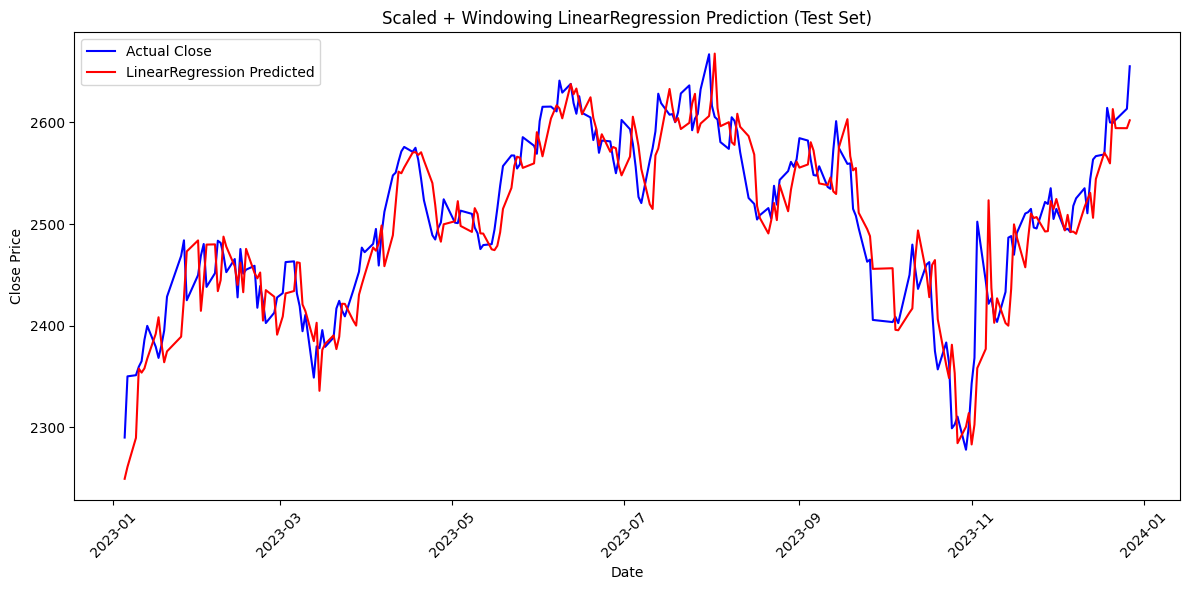

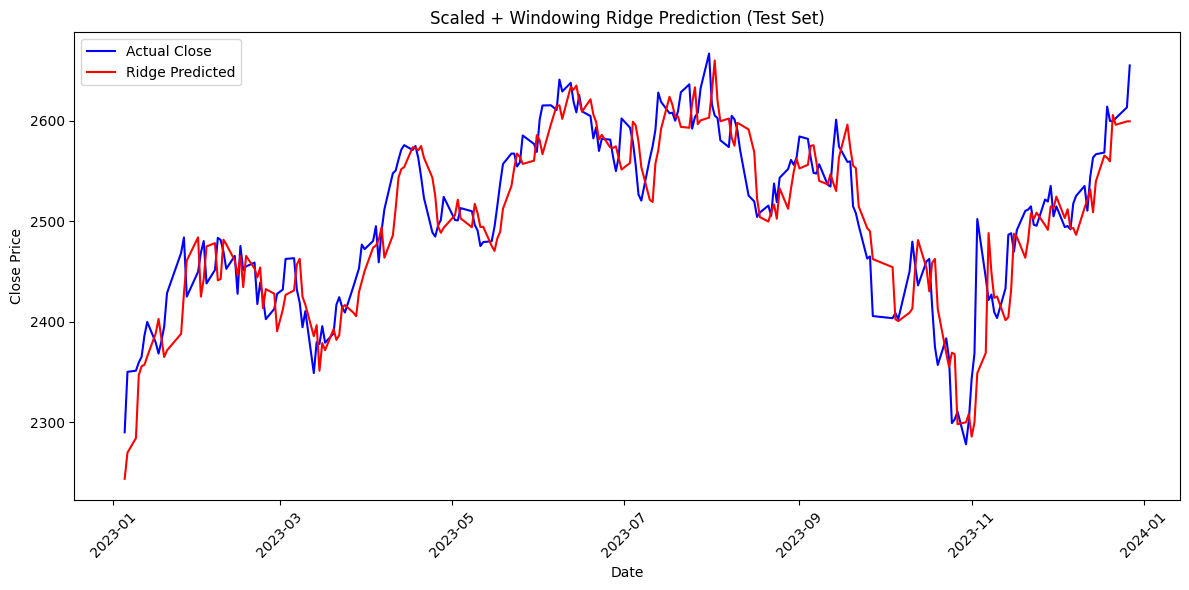

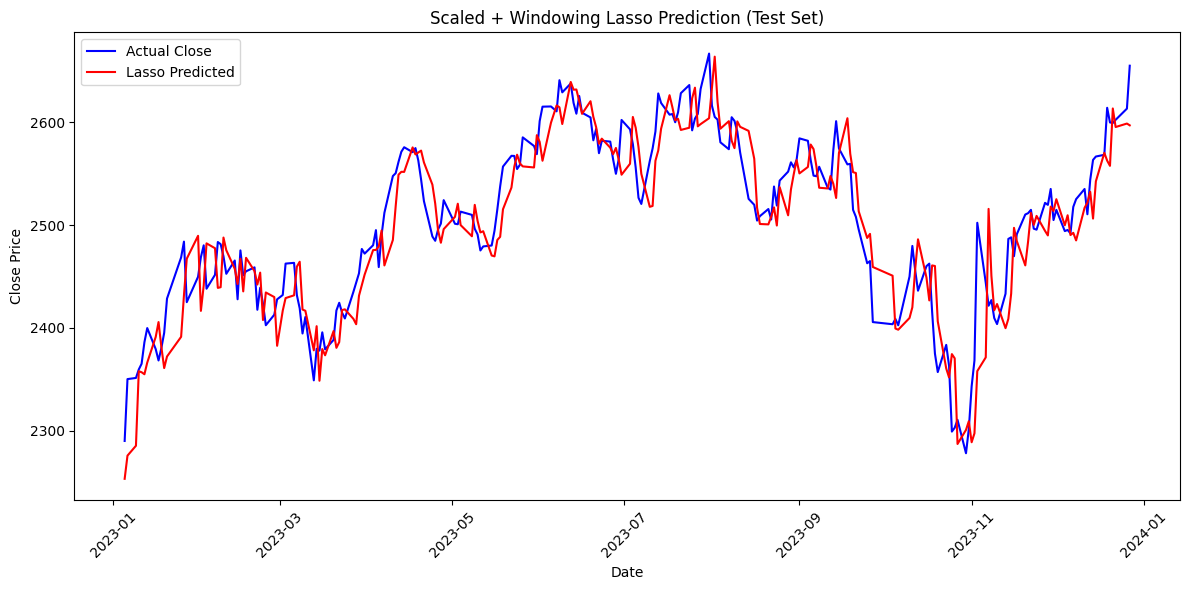

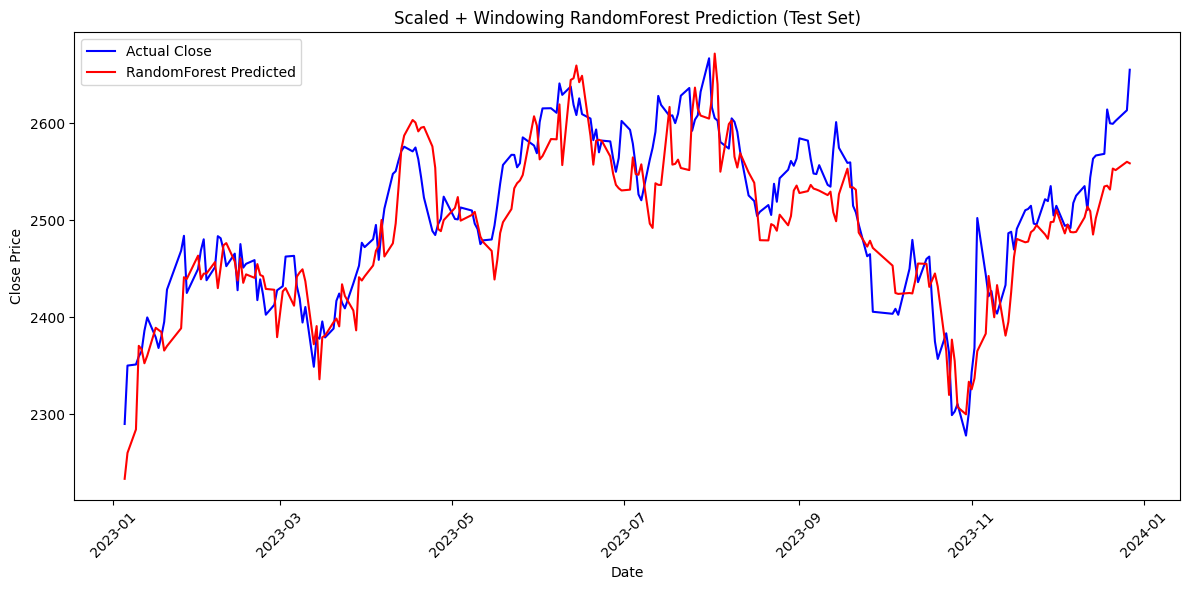

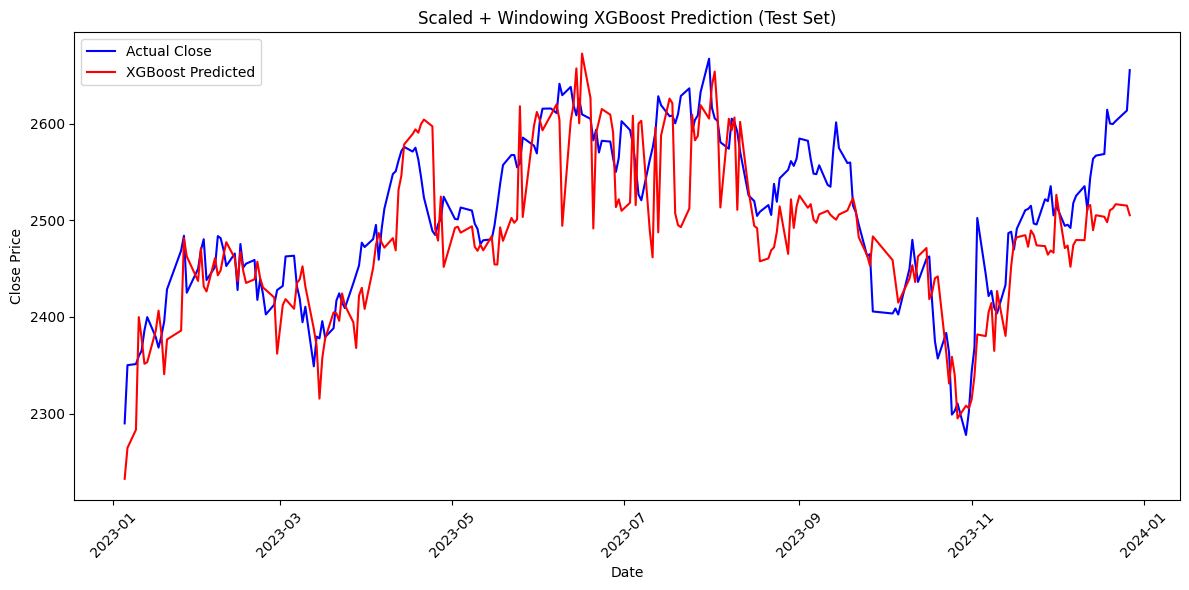

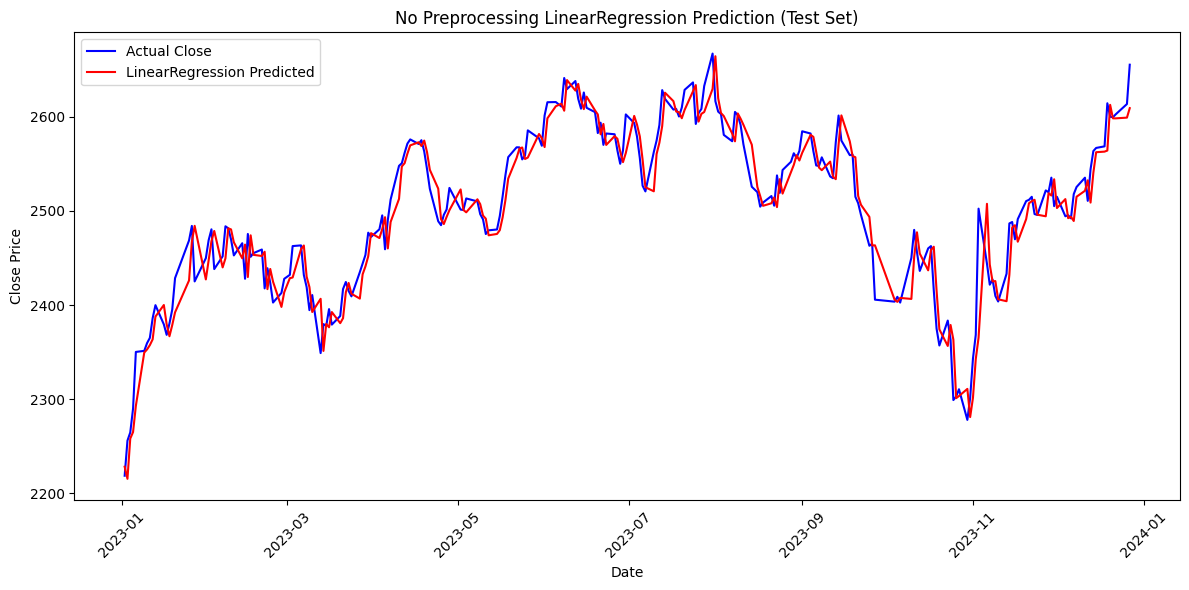

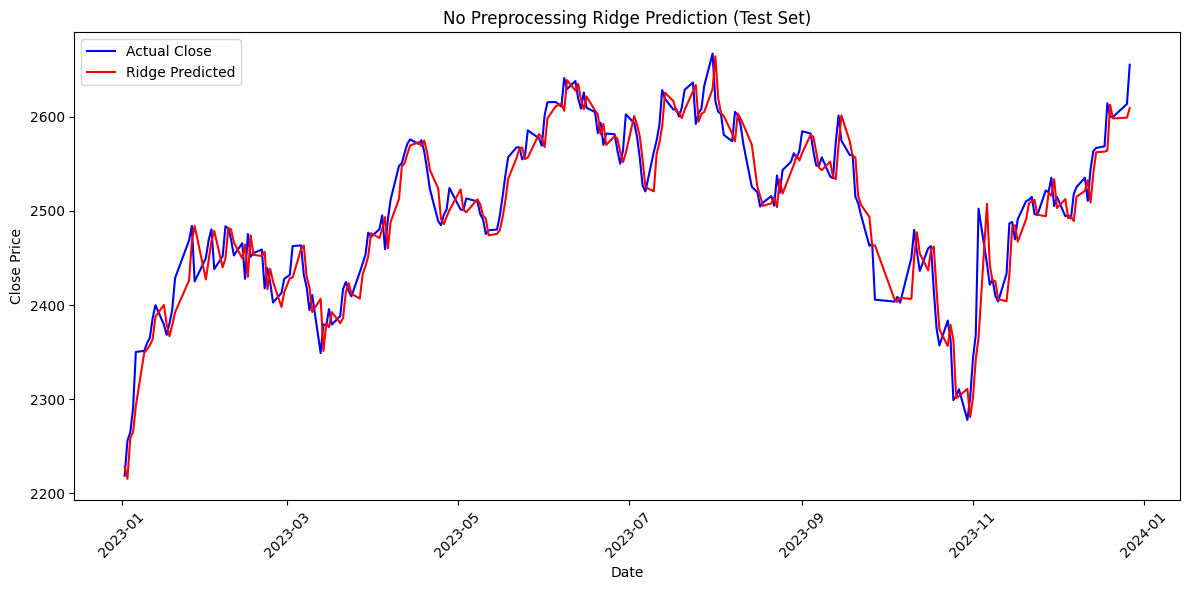

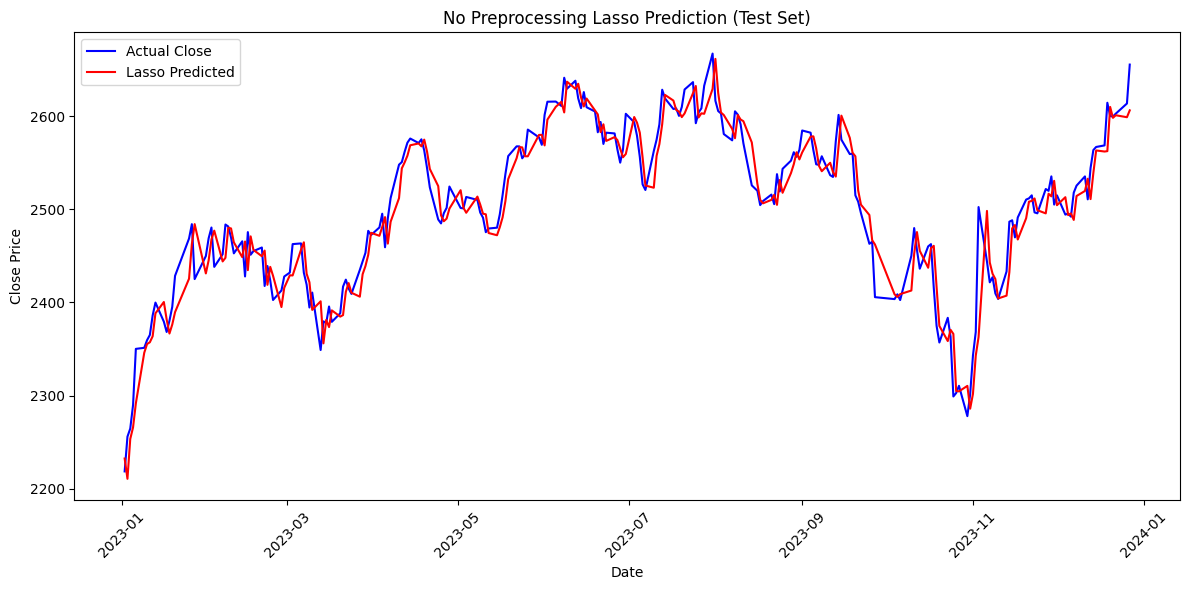

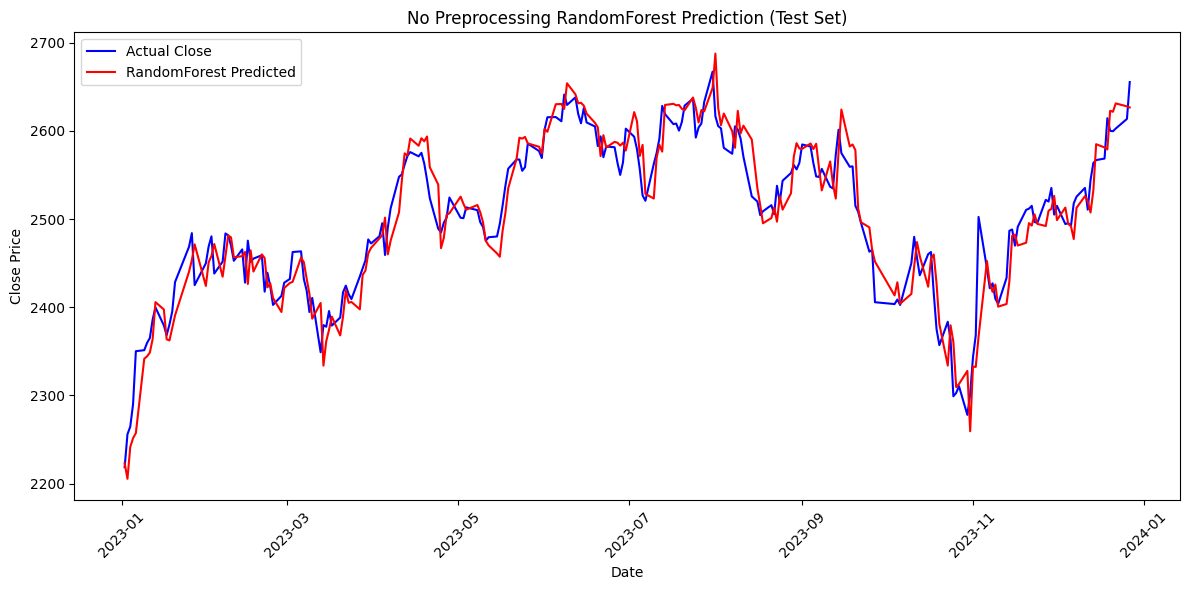

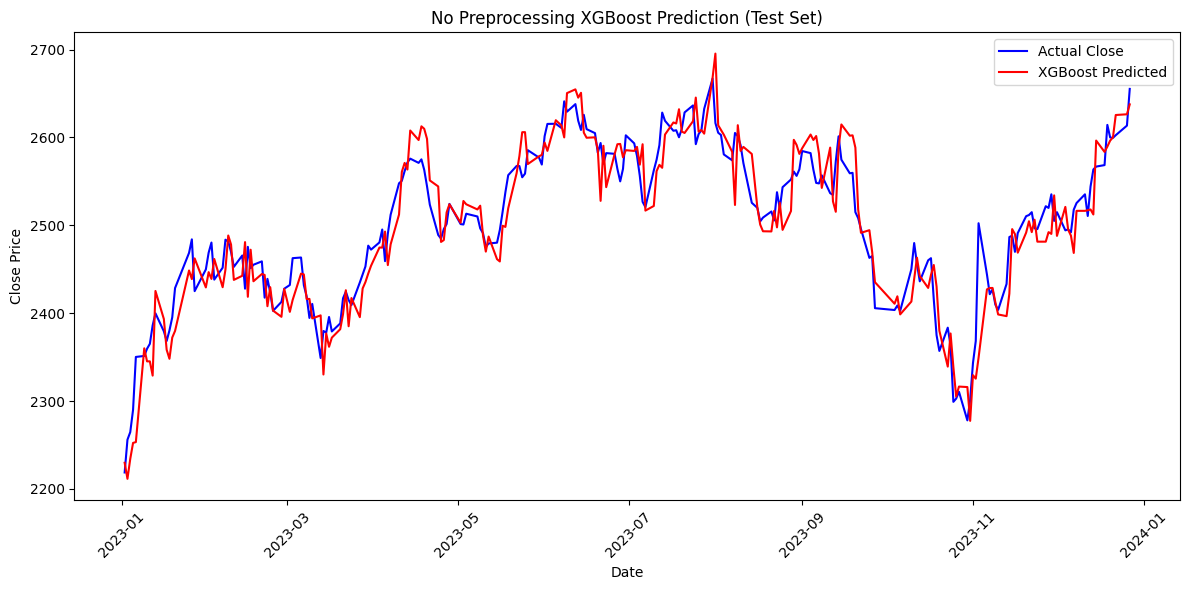

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(dates, y_true, predictions_dict, title_prefix=""):
    for name, y_pred in predictions_dict.items():
        plt.figure(figsize=(12, 6))
        plt.plot(dates, y_true, label='Actual Close', color='blue')
        plt.plot(dates, y_pred, label=f'{name} Predicted', color='red')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title(f'{title_prefix} {name} Prediction (Test Set)')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 전처리 적용 시각화
plot_predictions(dates_test_scaled, y_test_scaled, test_predictions_scaled, title_prefix="Scaled + Windowing")

# 전처리 미적용 시각화
plot_predictions(dates_test_raw, y_test_raw, test_predictions_raw, title_prefix="No Preprocessing")